In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X = 2 * np.random.rand(100,1)
y = 4 + 3 * X + np.random.randn(100,1)

## Linear regression model prediction

$y = \theta_0x_0 + \theta_1x_1 + \theta_2x_2 + .... + \theta_nx_n$

This can be written much more concisely using a vectorized form as shown below:

$y = h_{\theta}(x) = \theta.x$

- $\theta$ is the model's parameter vector, containing the bias term $\theta_0$ and the feature weights $\theta_1$ to $\theta_n$

add $x_0 = 1$ to each instance to create $x_b$ 

In [3]:
X_b = np.c_[np.ones((100,1)),X]
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best)

[[3.88618838]
 [3.10567672]]


We expected $\theta_{0}$ to be 4 and $\theta_{1}$ to be 3. Close enough, but the gaussian noise made it impossible to recover the exact parameters of the original function.

Now predicting the value of y using the theta_best

In [4]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new] # add x0 = 1 to each instance
y_predict = X_new_b @ theta_best
print(y_predict)

[[ 3.88618838]
 [10.09754182]]


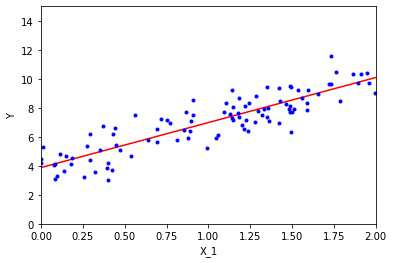

In [5]:
plt.plot(X_new,y_predict,"r-")
plt.plot(X,y,"b.")
plt.xlabel("X_1")
plt.ylabel("Y")
plt.axis([0,2,0,15])
plt.show()

The LinearRegression class is based on the np.linalg.lstsq() function which you could call directly. 

This function computes $\theta = X^+ y $, where $X^+$ is the **pseudoinverse** of X. You can use np.linalg.pinv() to compute the pseudo inverse directly.

In [6]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X_b,y,rcond = 1e-6)
theta_best_svd

array([[3.88618838],
       [3.10567672]])

In [7]:
np.linalg.pinv(X_b).dot(y)

array([[3.88618838],
       [3.10567672]])

The pseudoinverse itself is computed using a standard matrix factorization technique called **Singular Value Decomposition (SVD)** that can decompose the training set matrix X into the matrix multiplication of three matrices $ U, \sum, V^T$. The pseudoinverse is computed as $X^+ = V\sum^{+}U^T$.

The normal equation may not work if the matrix $X^TX$ is not invertible (i.e singular). Hence SVD method is normally used to calculate theta_best.

##### Computational Complexity
The normal equation for finding theta best is:  


$\theta = (X^TX)^{-1}X^Ty$

This equation computes the inverse of $X^TX$ which is an $(n+1)*(n+1)$ matrix (where n is the number of features). The *Computational complexity* of inverting such a matrix is typically about $O(n^{2.4})$ to $O(n^3)$ depending upon the implementation.  

The SVD approach used by Scikit-Learn's LinearRegression class is about $O(n^2)$. 


## Gradient Descent
### 1) Batch Gradient Descent
Now we will look at very different ways to train a Linear Regression model, better suited for cases where there are a large number of features, or too many training instances to fit in memory. 

The idea of Gradient Descent is to tweak parameters ($\theta$) iteratively in order to minimize a cost function.  

You can calculate the gradient descent using the following formula on the go.
$MSE(\theta) = \frac{2}{m} X^T(X\theta - y)$

and use this gradient to tweak the parameters ($\theta$)  

$ \theta^{(next step)} = \theta - \eta * MSE(\theta) $

where $\eta$ (eta) is the learning rate.


In [8]:
eta = 0.1 #learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) #random initialization of theta

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T @ (X_b @ theta - y)
    theta = theta - eta * gradients

print(theta)

[[3.88618838]
 [3.10567672]]


### 2) Stochastic Gradient Descent
The main problem with Batch Gradient Descent is the fact that it uses the whole training set to compute the gradients at every step, which makes it very slow when the training set is large. 

However, **Stochastic gradient descent** just picks a random instance in the training set at every step and computes the gradients based only on that single instance. This makes it possible to train on huge datasets, since only one instance needs to be in memory at each iteration.

Because of stochastic nature, the algorithm is much less regular than Batch Gradient Descent: instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average. Overtime it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down. So once the algorithm stops, the final parameter value are good, but not optimal. 

- When the cost function is very irregular, this can actually help the algorithm jump out of local minima, so SGD has a better chance of finding the global minimum than BGD.

To solve SGD problem, we can gradually reduce the learning rate. The step starts out with large learning rate, and then gets smaller and smaller, allowing the algorithm to settle at global minima. The function that determines the learning rate at each iteration is called the **learning schedule**. 

The implementation of SGD is below:

In [9]:
n_epochs = 50
t0,t1 = 5,50 # learning schedule hyperparameters. 

def learning_schedule(t):
    return t0 / (t + t1)

theta = np.random.randn(2,1) # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index:random_index+1]
        yi = y[random_index:random_index+1]
        gradients = 2 * xi.T @ (xi @ theta - yi)
        eta = learning_schedule(epoch * m + i)
        theta = theta - eta * gradients

In [10]:
theta

array([[3.91938581],
       [3.09216076]])

You can also use scikit-learn to implement SGD directly without using code as above. 

In [11]:
from sklearn.linear_model import SGDRegressor

In [12]:
sgd_reg = SGDRegressor(max_iter = 1000, tol= 1e-3, penalty = None, eta0 = 0.1)
sgd_reg.fit(X,y.ravel())

SGDRegressor(eta0=0.1, penalty=None)

In [13]:
sgd_reg.intercept_,sgd_reg.coef_

(array([3.8358715]), array([3.09376233]))

You can see from above that intercept nearly equals to 4 and coefficent equal to 3


### Mini-Batch Gradient descent

At each step, instead of computing the gradients based on the full training set (as in Batch GD) or based on just one instance (as in Stochastic GD), Mini-Batch GD computes the gradients on small random sets of instances called *mini-batches*. 

The main advantage of Mini-batch GD over Stochastic GD is that you can get a performance boost from hardware optimization of matrix operations, especially when using GPUs


## Polynomial regression

What if your data is actually more complex than a simple straight line? You can actually use a linear model to fit nonlinear data. A simple way to do this is to add powers of each features as new features, then train a linear model on this extended set of features. This technique is known as **Polynomial regression**. 


``` while the Normal equation can only perform Linear Regression, the Gradient Descent algorithms can be used to train many other models```

In [14]:
m = 100
X = 6 * np.random.rand(m,1) - 3 
y = 0.5 * X**2 + X + 2 + np.random.randn(m,1)

Text(0, 0.5, 'y')

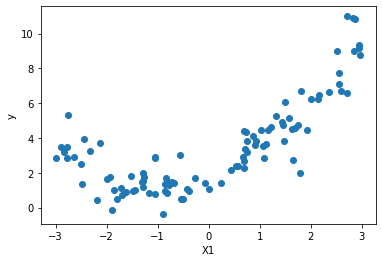

In [15]:
plt.scatter(X,y)
plt.xlabel('X1')
plt.ylabel('y')

Clearly, a straight line will never fit this data properly. So let's use Scikit-Learns PolynomialFeatures class to transform our training data, adding the square(2nd degree polynomial) of each feature in the training set as new features.

In [16]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [17]:
poly_features = PolynomialFeatures(degree = 2, include_bias = False)
X_poly = poly_features.fit_transform(X)
X[0]

array([-0.71274052])

In [18]:
X_poly[0]
# This contains the original feature of X and square of this feature.

array([-0.71274052,  0.50799905])

In [19]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)

LinearRegression()

In [20]:
lin_reg.intercept_,lin_reg.coef_

(array([1.80373462]), array([[1.04540444, 0.53626902]]))

This shows $ y = 0.48 x^2 + 1.04 x + 2.08 $, while the original equation was $ y = 0.5 x^2 + x + 2 + nosie_{gaussain} $. This is pretty close to the original equation

In [21]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model,X,y):
    X_train,X_val,y_train,y_val = train_test_split(X,y,test_size = 0.2)
    train_errors, val_errors = [],[]
    for m in range(1,len(X_train)):
        model.fit(X_train[:m],y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m],y_train_predict))
        val_errors.append(mean_squared_error(y_val,y_val_predict))
    plt.plot(np.sqrt(train_errors),'r-+',linewidth = 2,label = "train")
    plt.plot(np.sqrt(val_errors),'b-',linewidth=3,label="val")
    plt.legend()
    plt.xlabel('Training set size')
    plt.ylabel('RMSE')

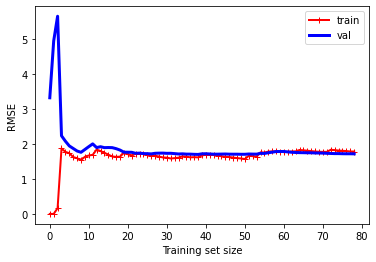

In [22]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg,X,y)

Now let's look at the learning curves of a 10th degree polynomial model on the same data

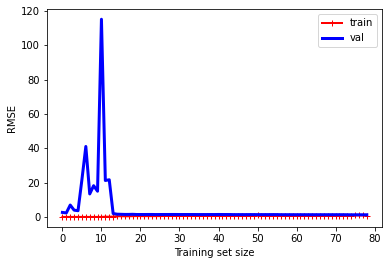

In [23]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
    ("poly_features",PolynomialFeatures(degree=10,include_bias = False)),
    ("lin_reg",LinearRegression())
])

plot_learning_curves(polynomial_regression,X,y)

## Regularized Linear Model
A good way to reduce overfitting is to regularize the model (i.e constrain it): the fewer degrees of freedom it has, the harder it will be for it to overfit the data. For eg: A simple way to regularize a polynomial model is to reduce the number of polynomial degrees. 

For a linear model, regularization is typically ahieved by constraining the weights of the model.

### 1) Ridge Regression:
- Regularized version of Linear regression: a regularization term equal to $\alpha\sum_{i=1}^{n}\theta_i^2$ is added to cost function.
- This forces the learning algorithm to not only fit the data but also keep the model weights as small as possible. 
- Ridge regression cost function:
$$ J(\theta) = MSE(\theta) + \alpha \frac{1}{2}\sum_{i=1}^{n}\theta_i^2$$